Statistical Methods applied on Academic collaboration network
==============

**Student:** Lorenzo Betti 

**Course:** Statistical methods in network science - 2022/2023

### Outline of the course project

Academic publications can be studied through the lens of social network analysis. Indeed, the scientific literature can be modeled as a bipartite network, in which a set of nodes correspond to authors (i.e., researchers) and the other set of nodes to pubblications (i.e., papers). The collaboration network between authors can thus be obtained by projecting this bipartite network onto the set of authors. Here, two authors are connected if they have co-authored at least one paper together. At this point, tools from network science can be used to better understand the factors that contribute to successful science, the relational structure between scientists, institutions, and ideas, and inequalities in academia [1].

Here, I want to investigate two features of a collaboration network:

**Q1**: Is the distribution of number of publication by male and female authors a power law?

**Q2**: Is the network assortative with respect to authors’ gender?

To do that, I will use the dataset of Ref. [2] containing all the publications of 16 peer reviewed journals under the Informs group. The dataset is composed of 23.875 publications and the 22.911 authors of these publications. Links between authors and publications indicate who are the authors of a publication. Authors' gender was obtained through a combination of authomatic methods (Genderize.io) and manual annotation, which resulted in 71% male, 13% female, and 16% unknown-gender authors.


### References

[1] Fortunato, Santo, et al. “Science of Science.” Science, vol. 359, no. 6379, Mar. 2018. Crossref, https://doi.org/10.1126/science.aao0185.

[2] Bravo-Hermsdorff, Gecia, et al. "Gender and collaboration patterns in a temporal scientific authorship network." Applied Network Science 4.1 (2019): 1-17.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pandas as pd
import networkx as nx
import powerlaw
from scipy import stats, integrate

from tqdm.notebook import tqdm
RNG = np.random.RandomState(42)

In [2]:
# set font properties
matplotlib.rc('figure', figsize=(6.4, 4.8)) 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rc('font', size=16)
matplotlib.rc('xtick.major', size=6, width=1)
matplotlib.rc('xtick.minor', size=3, width=1)
matplotlib.rc('ytick.major', size=6, width=1)
matplotlib.rc('ytick.minor', size=3, width=1)
matplotlib.rc('axes', linewidth=1)

### Load data

Dataset downloaded from the official repository of the paper: https://github.com/Gecia/INFORMS_TemporalGenderedAuthorshipNetwork

In [3]:
data_path = "../data/collab_network_bravo/"

# load authors, contains also the gender of each author estimated with genderize.io + manual refinement
authors = pd.read_csv(os.path.join(data_path, 'AuthorNodes.csv'), 
                      usecols=['Author_Node_ID', 'Gender_Label_Refined'])\
                        .rename(columns={'Author_Node_ID':'author_id',
                                         'Gender_Label_Refined':'gender'}).astype(str)

# load publications, contains the year of publications
publications = pd.read_csv(os.path.join(data_path, 'PublicationNodes.csv'),
                           converters={'Publication_Node_ID':str, 'Year':int})\
                            .rename(columns={'Publication_Node_ID':'publication_id', 'Year':'year'})


# load edges between authors and publications, contains the position of the author in the paper
edges = pd.read_csv(os.path.join(data_path, 'Edges.csv'), 
                    converters={'Publication_Node_ID':str, 'Author_Node_ID':str})\
                    .rename(columns={'Publication_Node_ID':'publication_id', 'Author_Node_ID':'author_id', 
                                     'Author_Position':'position'})

# load as networkx graph, then get projection onto authors and assign gender as node label
G = nx.from_pandas_edgelist(edges, source='author_id', target='publication_id')
G_authors = nx.bipartite.project(G, authors.author_id)
nx.set_node_attributes(G_authors, authors.set_index('author_id').to_dict()['gender'], name='gender')

print("Bipartite network")
print("Number of authors: ", authors.shape[0])
print("Number of publications: ", publications.shape[0])
print("Number of edges: ", edges.shape[0])
print()
print("Collaboration network")
print("Number of nodes: ", G_authors.number_of_nodes())
print("Number of edges: ", G_authors.number_of_edges())

Bipartite network
Number of authors:  22911
Number of publications:  23875
Number of edges:  50527

Collaboration network
Number of nodes:  22911
Number of edges:  37070


In [4]:
# consider data only from the biggest CC
G = nx.from_pandas_edgelist(edges, source='author_id', target='publication_id')
G = G.subgraph(max(nx.connected_components(G), key=len))

# count how many publications and authors we have removed
n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()
n_authors_ = len(set(G.nodes()).intersection(authors.author_id))
n_publications_ = n_nodes - n_authors_

# print new number basic statistic
# between parentheses, fraction wrt the instances in the original datase
print(f"Number of nodes: {n_nodes} ({round(n_nodes/(authors.shape[0] + publications.shape[0]) * 100, 2)}%)")
print(f"Number of edges: {n_edges} ({round(n_edges/edges.shape[0] * 100, 2)}%)")
print(f"Number of authors: {n_authors_} ({round(n_authors_/authors.shape[0] * 100, 2)}%)")
print(f"Number of publications: {n_publications_} ({round(n_publications_/publications.shape[0] * 100, 2)}%)")

# filter accordingly the dataframes
authors = authors[authors.author_id.isin(G.nodes())].reset_index(drop=True)
publications = publications[publications.publication_id.isin(G.nodes())].reset_index(drop=True)
edges = edges[(edges.author_id.isin(authors.author_id))].reset_index(drop=True)

Number of nodes: 30124 (64.39%)
Number of edges: 38169 (75.54%)
Number of authors: 13520 (59.01%)
Number of publications: 16604 (69.55%)


### **Q1**: Is the distribution of number of publication by male and female authors a power law?

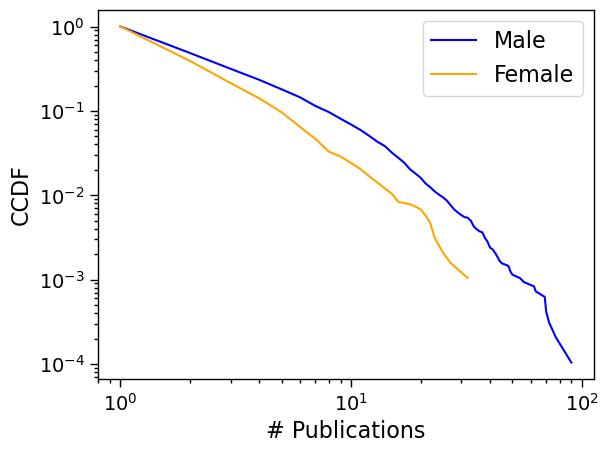

In [5]:
# plot CCDF also of male and female authors
k_authors = []
k_authors_male = []
k_authors_female = []
authors = authors.set_index('author_id')
for node, deg in G.degree(authors.index):
    
    k_authors.append(deg)
    gender_ = authors.loc[node].gender
    if gender_ == 'male':
        k_authors_male.append(deg)
    elif gender_ == 'female':
        k_authors_female.append(deg)
        
authors = authors.reset_index()

# plot
#powerlaw.plot_ccdf(k_authors, label='All')
powerlaw.plot_ccdf(k_authors_male, label='Male', color='blue')
powerlaw.plot_ccdf(k_authors_female, label='Female', color='orange')

plt.xlabel("# Publications")
plt.ylabel("CCDF")
plt.legend()

First, the maximum number of publications between male and female authors is different, being slightly less than 100 for male and around 30 for female authors. This signals an important difference between male and female authors.

Second, both distributions do not fully span two orders of mangitude, thus making it difficult to assess whether the power law is a good hypothesis to explain the above distributions. 

To fit the two distributions, I will follow Ref.[a] , in which the whole process is divided into 3 steps.

[a] Clauset, Aaron, Cosma Rohilla Shalizi, and Mark EJ Newman. "Power-law distributions in empirical data." SIAM review 51.4 (2009): 661-703.

#### Q1.a Are these distributions power laws?

First estimate the parameters of the power law: $\alpha$ and $x_{min}$.

Calculating best minimal value for power law fit
/mnt/sdb1/lorenzo/miniconda3/envs/env-final-project-collaborations/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/mnt/sdb1/lorenzo/miniconda3/envs/env-final-project-collaborations/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit


Male:
alpha = 3.463 ± 0.128, x_min = 14
Feale:
alpha = 2.967 ± 0.145, x_min = 5


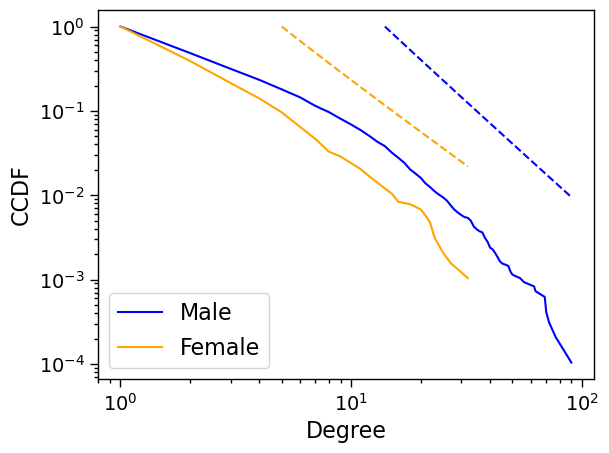

In [6]:
# estimate xmin and alpha
fit_male = powerlaw.Fit(k_authors_male, discrete=True)
fit_female = powerlaw.Fit(k_authors_female, discrete=True)

# plot the fits
fig1 = powerlaw.plot_ccdf(k_authors_male, label='Male', color='blue')
fit_male.power_law.plot_ccdf(color='blue', linestyle='dashed', ax=fig1)
powerlaw.plot_ccdf(k_authors_female, label='Female', color='orange', ax=fig1)
fit_female.power_law.plot_ccdf(color='orange', linestyle='dashed', ax=fig1)

plt.xlabel("Degree")
plt.ylabel("CCDF")
plt.legend()

print("Male:")
print(f"alpha = {fit_male.alpha:.4} ± {fit_male.sigma:.3}, x_min = {int(fit_male.xmin)}")
print("Feale:")
print(f"alpha = {fit_female.alpha:.4} ± {fit_female.sigma:.3}, x_min = {int(fit_female.xmin)}")

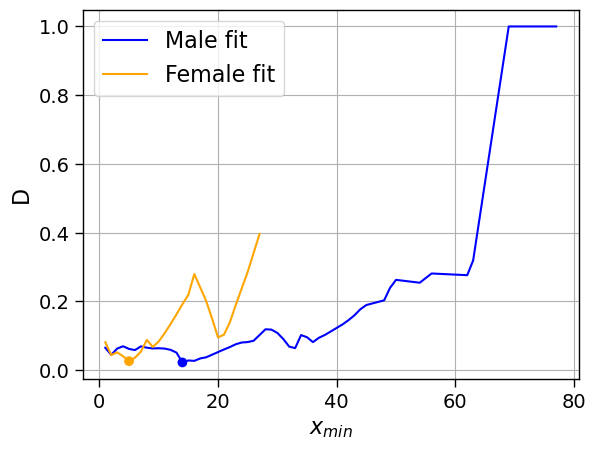

In [7]:
# show the D
plt.plot(fit_male.xmins, fit_male.Ds, label="Male fit", color='blue')
plt.plot(fit_female.xmins, fit_female.Ds, label="Female fit", color='orange')
plt.scatter(np.array([fit_male.xmin, fit_female.xmin]), np.array([fit_male.D, fit_female.D]),
           c=['blue', 'orange'])
plt.xlabel(r"$x_{min}$")
plt.ylabel("D")

plt.legend()
plt.grid()

The Male fit shows that there is another local minimum for a lower value of D. However, I choose to stick with the optimal value returned by this test.

Perform the goodness of fit.

In [8]:
# goodness of fit
# generate data from the fitted distribution, add the head of the distribution, and fit it again
# then show distribution of D
N_ITERS = 1000

head_male = np.array([k for k in k_authors_male if k < fit_male.xmin])
head_female = np.array([k for k in k_authors_female if k < fit_female.xmin])
D_male_simul = []
D_female_simul = []

for _ in tqdm(range(N_ITERS), total=N_ITERS):
    
    # generate data from fitted distribution
    k_authors_male_simul = fit_male.power_law.generate_random(n=int(fit_male.n_tail), )
    k_authors_male_simul = np.hstack([head_male, k_authors_male_simul])
    k_authors_female_simul = fit_female.power_law.generate_random(n=int(fit_female.n_tail), )
    k_authors_female_simul = np.hstack([head_female, k_authors_female_simul])
    
    # fit the simulated distribution
    fit_male_simul = powerlaw.Fit(k_authors_male_simul, discrete=True, verbose=False)
    fit_female_simul = powerlaw.Fit(k_authors_female_simul, discrete=True, verbose=False)
    D_male_simul.append(fit_male_simul.D)
    D_female_simul.append(fit_female_simul.D)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
# test the generated distributions against the original fitted one
# the null hypothesis is that the power law describes the data
D_male_simul = np.array(D_male_simul)
D_female_simul = np.array(D_female_simul)

p_male = (D_male_simul > fit_male.D).mean()
is_pl_male = p_male > 0.1
p_male = f"p = {round(p_male, 4)}" if p_male > 0.0001 else "p < 0.0001"
p_female = (D_female_simul > fit_female.D).mean()
is_pl_female = p_female > 0.1
p_female = f"p = {round(p_female, 4)}" if p_female > 0.0001 else "p < 0.0001"

print(f"Male: {p_male}.")
print(f"Female: {p_female}.")


Male: p = 0.752.
Female: p = 0.854.


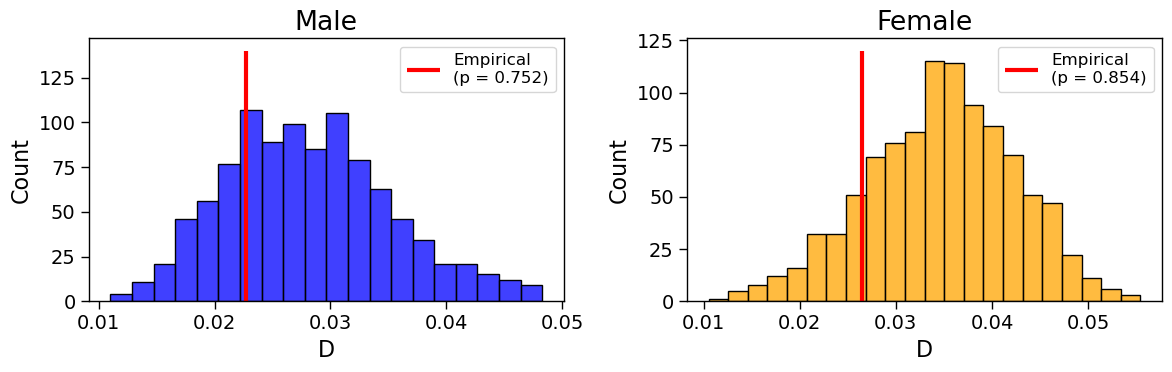

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
sns.histplot(D_male_simul, color='blue')
plt.vlines(fit_male.D, 0, 140, color='red', linewidth=3, label=f'Empirical\n({p_male})')
plt.title("Male")
plt.xlabel("D")
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(D_female_simul, color='orange')
plt.vlines(fit_female.D, 0, 120, color='red', linewidth=3, label=f'Empirical\n({p_female})')
plt.title("Female")
plt.xlabel("D")
plt.legend(fontsize=12)

plt.tight_layout()

The test shows that the power law is a plausible distribution for the data.

Finally, compare with alternative distributions.

In [11]:
# get list of classes under powerlaw to see the available distributions
[class_name for class_name in dir(powerlaw) 
 if callable(getattr(powerlaw, class_name)) and not class_name.startswith("__") and class_name[0].isupper()]

['Distribution',
 'Distribution_Fit',
 'Exponential',
 'Fit',
 'Lognormal',
 'Lognormal_Positive',
 'Power_Law',
 'Stretched_Exponential',
 'Truncated_Power_Law']

In [12]:
def show_params_distribution(fit_obj):
    """ Take a fitted object and return all the parameters of the distribution.
    """
    
    param_names = [attrib for attrib in dir(fit_obj) 
               if attrib.startswith("parameter") and attrib.endswith("_name")]

    return [(getattr(fit_obj, param_name), getattr(fit_obj, param_name.split("_")[0])) 
            for param_name in param_names if getattr(fit_obj, param_name)]

In [13]:
alternative_hypotheses = ['Exponential', 'Lognormal', 'Lognormal_Positive', 
                          'Stretched_Exponential', 'Truncated_Power_Law']

for fit_, fit_name in zip([fit_male, fit_female], ['male', 'female']):
    print(fit_name.title())
    for alternative_hp in alternative_hypotheses:
        R, p = fit_.distribution_compare('power_law', alternative_hp.lower())
        p = f"p = {round(p, 4)}" if p > 0.0001 else "p < 0.0001"
        print("Alternative hypothesis: ", alternative_hp)
        print("Fitted parameters: ", 
              " - ".join([f"{param_n} = {param:.4f}" 
               for param_n, param in show_params_distribution(getattr(fit_, alternative_hp.lower()))]))
        print(f"R = {round(R, 4)} ({p})\n")
    print("*-" * 20)

Male
Alternative hypothesis:  Exponential
Fitted parameters:  lambda = 0.1180
R = 12.028 (p = 0.073)

Alternative hypothesis:  Lognormal
Fitted parameters:  mu = -0.1467 - sigma = 1.1901
R = -1.4699 (p = 0.2596)

Alternative hypothesis:  Lognormal_Positive
Fitted parameters:  mu = 0.0000 - sigma = 1.1648
R = -1.4675 (p = 0.281)

Alternative hypothesis:  Stretched_Exponential
Fitted parameters:  lambda = 170.7228 - beta = 0.2714
R = -1.6014 (p = 0.2499)



/mnt/sdb1/lorenzo/miniconda3/envs/env-final-project-collaborations/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Assuming nested distributions


Alternative hypothesis:  Truncated_Power_Law
Fitted parameters:  alpha = 2.7673 - lambda = 0.0221
R = -1.959 (p = 0.0478)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Female
Alternative hypothesis:  Exponential
Fitted parameters:  lambda = 0.2523
R = 10.177 (p = 0.0348)

Alternative hypothesis:  Lognormal
Fitted parameters:  mu = -2.3101 - sigma = 1.5432
R = -0.6403 (p = 0.3229)

Alternative hypothesis:  Lognormal_Positive
Fitted parameters:  mu = 0.0000 - sigma = 1.1087
R = -0.2085 (p = 0.8795)

Alternative hypothesis:  Stretched_Exponential
Fitted parameters:  lambda = 3032.4988 - beta = 0.2201
R = -0.7502 (p = 0.3245)



Assuming nested distributions


Alternative hypothesis:  Truncated_Power_Law
Fitted parameters:  alpha = 2.4949 - lambda = 0.0382
R = -1.1896 (p = 0.123)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


- Male distribution is more suitable for a Truncated power law
- Female distribution is more suitable for a power law (wins against Exponential)

Calculating best minimal value for power law fit
/mnt/sdb1/lorenzo/miniconda3/envs/env-final-project-collaborations/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit


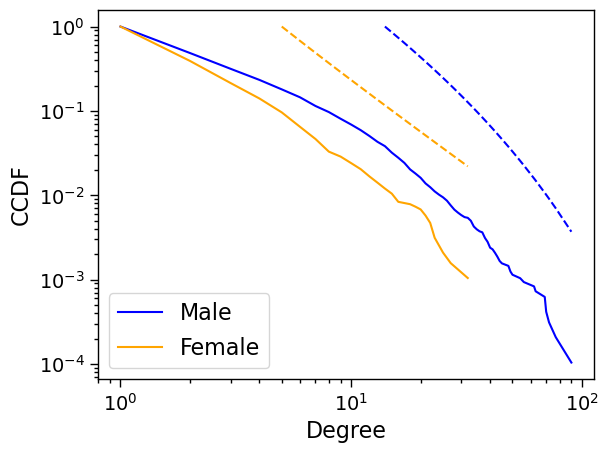

In [14]:
# plot final distributions

fit_male = powerlaw.Fit(k_authors_male, discrete=True)
fit_female = powerlaw.Fit(k_authors_female, discrete=True)

fig1 = powerlaw.plot_ccdf(k_authors_male, color='blue', label='Male')
fit_male.truncated_power_law.plot_ccdf(color='blue', linestyle='dashed', ax=fig1)
powerlaw.plot_ccdf(k_authors_female, color='orange', ax=fig1, label='Female')
fit_female.power_law.plot_ccdf(color='orange', linestyle='dashed', ax=fig1)

plt.xlabel("Degree")
plt.ylabel("CCDF")
plt.legend()

#### Conclusion

The distribution of the number of publications of male authors is better described by a truncated power law, with cut-off at around 50 publications. On the other hand, the power law results a good hypothesis for the distribution of female authors.

However, the small scale of the distributions (max publications of male and females are 90 and 30 approx.) is a limitation that makes it difficult to fully rely on the previous fits. A possible improvement consists in replacing the Kolmogorov–Smirnov test with other tests whose statistical power depends on the size of the sample.

### **Q2**: Is the network assortative with respect to authors’ gender?

To measure the gender assortativity of the collaboration network, I measure the Newman's attribute assortativity. In addition to it, I use two other measures in order to disentangle the relative effect of men and women in the observed assortativity [a].

The measures are:
$$ H_m = \frac{E_{m,m}}{E_{m,m} + E_{f,m}} $$
$$ H_f = \frac{E_{f,f}}{E_{f,f} + E_{f,m}} $$
where $E_{x,y}$ is the number of edges between gender $x$ and $y$.

Both assortativity and fraction of male-male and female-female links are compared against a null model in which pairs of edges are swapped randomly.

Note: I have made two modifications that returns slightly different results than the ones shown during the presentation. I have doubled the number of random swaps. This was done because the assortativity of the null model increased in time as well with a smaller number of swaps.

[a] Jadidi, Mohsen, et al. "Gender disparities in science? Dropout, productivity, collaborations and success of male and female computer scientists." Advances in Complex Systems 21.03n04 (2018): 1750011.

In [15]:
def proportion_links_gender(G):
    """ Compute the fraction of male-male and female-female edges.
    """
    
    assort_matrix = nx.attribute_mixing_matrix(G, attribute='gender', 
                                               mapping={'male':0, 'female':1, 'unknown':2})
    
    Hm = assort_matrix[0,0] / assort_matrix[0].sum() if assort_matrix[0].sum() > 0 else 0
    Hf = assort_matrix[1,1] / assort_matrix[1].sum() if assort_matrix[1].sum() > 0 else 0
    
    return Hm, Hf


def z_score(val, vals_null):
    return (val - np.mean(vals_null)) / np.std(vals_null) if np.std(vals_null) > 0 else 0


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [16]:
N_ITERS = 100

homophily_df = []
#pbar = tqdm(total=publications.year.nunique())
#for year, rows in publications.groupby(pd.Grouper('year', sort=True)):
y_bins = np.arange(1950, 2020, step=5)
pbar = tqdm(total=y_bins.shape[0]-1)
for year_l, year_u in zip(y_bins[:-1], y_bins[1:]):
    
    rows = publications[(publications.year>=year_l)&(publications.year<year_u)]
    if rows.shape[0] < 50:
        # if few publication, continue
        pbar.update(1)
        continue
        
    year = year_l
                
    # build the network from the publication of this year and project to users
    # remove paper '5002260', authored by ~30 authors with unknown gender.
    # I remove all papers authored by more than 20 authors
    edges_year = edges[edges.publication_id.isin(rows.publication_id)]
    n_authors_per_paper = edges.groupby('publication_id').size()
    edges_year = edges_year[edges_year.publication_id.isin(n_authors_per_paper[n_authors_per_paper < 10].index)]
    G_year = nx.from_pandas_edgelist(edges_year, 
                                     source='author_id', target='publication_id')
    G_year_users = nx.bipartite.project(G_year, nodes=edges_year.author_id.unique())
    
    nx.set_node_attributes(G_year_users, 
                           authors[authors.author_id.isin(edges_year.author_id.unique())]\
                                                   .set_index('author_id').to_dict()['gender'], 
                           name='gender')

    assort_all = nx.attribute_assortativity_coefficient(G_year_users, attribute='gender')
    authors_gendered_set = set(edges_year.author_id)\
                                .intersection(authors.query("gender != 'unknown'").author_id)
    assort_gendered = nx.attribute_assortativity_coefficient(G_year_users, attribute='gender', 
                                       nodes=authors_gendered_set)
    Hm, Hf = proportion_links_gender(G_year_users)
    
    # null model
    assort_gendered_rand = []
    Hms_rand, Hfs_rand = [], []
    for _ in range(N_ITERS):
        G_sw = nx.Graph(G_year_users)
        nx.double_edge_swap(G_sw, nswap=G_sw.number_of_edges()*2, max_tries=G_sw.number_of_edges()*10, seed=RNG)
        assort_gendered_ = nx.attribute_assortativity_coefficient(G_sw, attribute='gender', 
                                       nodes=authors_gendered_set)
        Hm_r, Hf_r = proportion_links_gender(G_sw)
        assort_gendered_rand.append(assort_gendered_)
        Hms_rand.append(Hm_r)
        Hfs_rand.append(Hf_r)
        
    z_Hm = z_score(Hm, Hms_rand)
    z_Hf = z_score(Hf, Hfs_rand)
    ass_r, ass_r_l, ass_r_u = mean_confidence_interval(assort_gendered_rand, confidence=0.95)
    homophily_df.append([year, assort_all, assort_gendered, ass_r, ass_r_l, ass_r_u, z_Hm, z_Hf])
    pbar.update(1)
    
homophily_df = pd.DataFrame(homophily_df, columns=['year', 'assort', 'assort_gendered',
                                                  'assort_null', 'assort_null_l', 'assort_null_u',
                                                  'z_Hm', 'z_Hf'])

  0%|          | 0/13 [00:00<?, ?it/s]

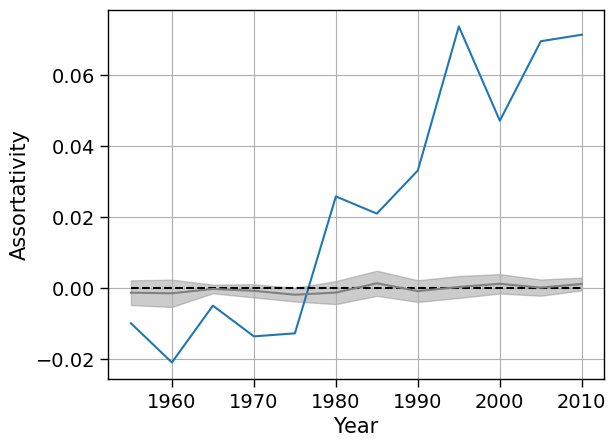

In [17]:
#sns.lineplot(homophily_df, x='year', y='assort')
sns.lineplot(homophily_df, x='year', y='assort_gendered')
plt.hlines(0, homophily_df.year.min(), homophily_df.year.max(), color='k', linestyle='dashed')

plt.fill_between(homophily_df.year, homophily_df.assort_null_l, homophily_df.assort_null_u, color='grey', alpha=0.4)
plt.plot(homophily_df.year, homophily_df.assort_null, color='grey')

plt.ylabel("Assortativity", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.grid()


Text(0.5, 0, 'Year')

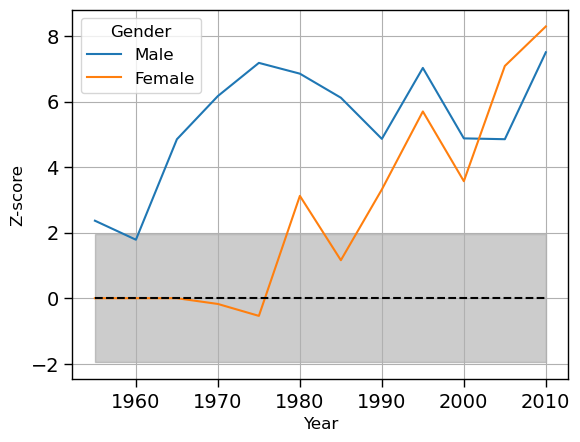

In [18]:
sns.lineplot(homophily_df, x='year', y='z_Hm', label='Male')
sns.lineplot(homophily_df, x='year', y='z_Hf', label='Female')

# this is significativity level of z-score
plt.fill_between(homophily_df.year, -1.96, 1.96, color='grey', alpha=0.4)
plt.hlines(0, homophily_df.year.min(), homophily_df.year.max(), color='k', linestyle='dashed')
plt.grid()
plt.legend(title='Gender', fontsize=12, title_fontsize=12)

plt.ylabel("Z-score", fontsize=12)
plt.xlabel("Year", fontsize=12)

Gender assortativity starts to increase starting from the early 80s, reaching values close to 0.07 that is far from what predicted by the null model. This corresponds to the increase of female-female edges as can be seen from the z-score.

### Conclusions

In this project, I have explored a dataset of scientific collaborations represented as a bipartite network between authors and publications. I have focused on two specific aspects. In **Q1**, I have tested whether the distribution of the number of publications of male and female authors can be represented by a power law distribution. The tests return a positive answer for female authors, while a truncated power-law distribution is more suited for males. In **Q2**, I have measured the gender assortativity of the collaboration network, showing that gender assortativity in the collaboration network increases starting from 1980s, both driven by male and female authors. This observation is significant when tompared to a null model in which edges are rewired at random.

These analyses suffer from different limitations that can be addressed in future projects. First, the sample used to fit the degree distribution is small and spans only two orders of magnitude, thus making it difficult to rely on power law fit. This could be addressed by replacing the KS test with other tests that take into account the sample size. Regarding the assortativity, the employed null model might be too simple. Indeed, it would be useful to explore other null models that are more grounded on the way authors publish papers (e.g., rewire taking into account seniority of authors, or rewire the bipartite network directly). Also, the unbalance in the number of male and female authors might play a role, and it would be worth to explore null models that can control for this unbalance.